# Setup

In [1]:
# widen jupyter notebook window
from IPython.display import display, HTML
display(HTML("<style>.container {width:95% !important; }</style>"))

# check environment
import os
print(f'Conda Environment: ' + os.environ['CONDA_DEFAULT_ENV'])

from platform import python_version
print(f'python version: {python_version()}')

Conda Environment: rich_clust
python version: 3.9.12


In [2]:
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import natsort

import torch
# from kymatio.torch import Scattering2D

import gc
import time
import functools
import multiprocessing as mp


In [3]:
tic = time.time()
toc = {}
toc['start'] = time.time() - tic

In [4]:
# params = {
#     'dir_github': r'/media/rich/Home_Linux_partition/github_repos/',
#     'dir_allOuterFolders': r"/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/4th_email/AllStatFiles/rbp10",
#     'pathSuffixToStat': 'plane1/stat.npy',
#     'pathSuffixToOps': 'plane1/ops.npy',
#     'pref_use_NN_distances': True,
#     'use_GPU': True,
#     'pref_blurROIs': True,
#     'params_blur': {
#         'kernel_size': 7, # Edge length of kernel image. Make odd number.
#         'kernel_width': 2.1, # width of 1 full cosine cycle for the 2d cosine kernel. Use width=2 for a single pixel.
#     },
#     'mask_power': 1, ## This parameter determines how 'binary'-looking masks are. Small values = more binary. Large values weight bright pixels more. mask_scaled = mask**mask_power
#     'params_dIOU': {
#         'algorithm': 'brute', ## Can be 'brute', 'auto', or anything from sklearn.neighbors.NearestNeighbors
#         'n_neighbors': 'full', ## Can either be an int or 'full', in which case the output will not be sparse
#     }
# }

In [5]:
dir_github = Path(r'/media/rich/Home_Linux_partition/github_repos/').resolve()

import sys
sys.path.append(str(dir_github))

In [6]:
# device = torch_helpers.set_device(use_GPU=params['use_GPU'])

In [8]:
%load_ext autoreload
%autoreload 2
from roicat import data_importing, helpers, ROInet
from roicat.tracking import visualization, alignment, blurring, scatteringWaveletTransformer, similarity_graph, clustering

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
%matplotlib notebook

# Import paths

In [10]:
# dir_allOuterFolders = Path(r"/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/4th_email/AllStatFiles/rbp16").resolve()
# dir_allOuterFolders = Path(r"/media/rich/bigSSD/res2p/scanimage data/round 5 experiments/mouse 2_6/just_stat_files").resolve()
dir_allOuterFolders = Path(r"/media/rich/bigSSD/other lab data/Harvey_lab_ROIs/Sofia_ROIs/Data for Rich/SS40/").resolve()

folders_allSessions = natsort.natsorted(helpers.get_dir_contents(dir_allOuterFolders)[0])[:2]

dir_allS2pFolders = [dir_allOuterFolders / folder for folder in folders_allSessions]

pathSuffixToStat = 'Slice06/stat.npy'
pathSuffixToOps = 'Slice06/ops.npy'
# pathSuffixToStat = 'stat.npy'
# pathSuffixToOps = 'ops.npy'

paths_allStat = np.array([path / pathSuffixToStat for path in dir_allS2pFolders])[:]
paths_allOps  = np.array([path / pathSuffixToOps for path in dir_allS2pFolders])[:]
# paths_allStat = np.array([path / pathSuffixToStat for path in dir_allS2pFolders])
# paths_allOps  = np.array([path / pathSuffixToOps for path in dir_allS2pFolders])

print(f'folder names of all sessions: \n{folders_allSessions}')
print(f'paths to all stat files: \n{paths_allStat}')
print(f'paths to all ops files: \n{paths_allOps}')


folder names of all sessions: 
['200130', '200131']
paths to all stat files: 
[PosixPath('/media/rich/bigSSD/other lab data/Harvey_lab_ROIs/Sofia_ROIs/Data for Rich/SS40/200130/Slice06/stat.npy')
 PosixPath('/media/rich/bigSSD/other lab data/Harvey_lab_ROIs/Sofia_ROIs/Data for Rich/SS40/200131/Slice06/stat.npy')]
paths to all ops files: 
[PosixPath('/media/rich/bigSSD/other lab data/Harvey_lab_ROIs/Sofia_ROIs/Data for Rich/SS40/200130/Slice06/ops.npy')
 PosixPath('/media/rich/bigSSD/other lab data/Harvey_lab_ROIs/Sofia_ROIs/Data for Rich/SS40/200131/Slice06/ops.npy')]


In [11]:
toc['import_paths'] = time.time() - tic

# Import data

In [15]:
data = data_importing.Data_suite2p(
    paths_statFiles=paths_allStat,
    paths_opsFiles=paths_allOps,
    um_per_pixel=2.0,
    new_or_old_suite2p='new',
    verbose=True,
)

data.import_ROI_centeredImages(
    out_height_width=[36,36],
    max_footprint_width=1025,
);

data.import_FOV_images(
    type_meanImg='meanImgE',
    images=None
);

data.import_ROI_spatialFootprints(workers=-1);

Starting: Importing spatial footprints from stat files
Completed: Imported 2 stat files into class as self.statFiles. Total number of ROIs: 1438. Number of ROI from each file: [706, 732]


2it [00:00, 24.44it/s]

Converted 2 spatial footprint files into small centered images in self.ROI_images.
Imported 2 FOV images into class as self.FOV_images
Importing spatial footprints from stat files.


Imported 2 sessions of spatial footprints into sparse arrays.


<IPython.core.display.Javascript object>


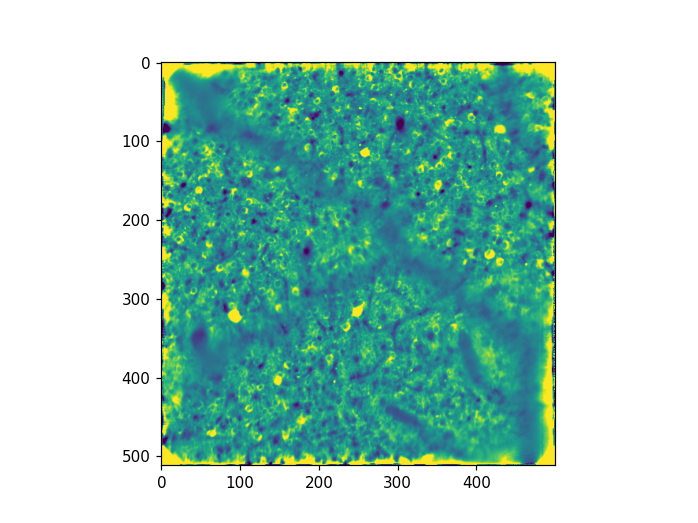

interactive(children=(IntSlider(value=0, description='i_frame', max=1), Output()), _dom_classes=('widget-inter…

<IPython.core.display.Javascript object>


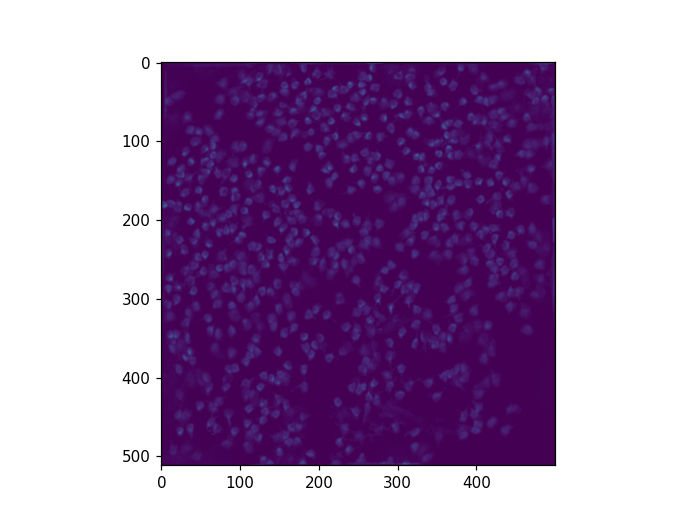

interactive(children=(IntSlider(value=0, description='i_frame', max=1), Output()), _dom_classes=('widget-inter…

<IPython.core.display.Javascript object>


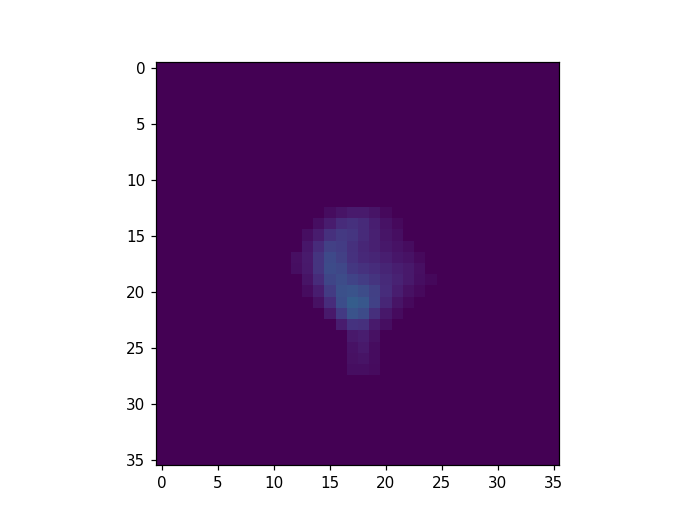

interactive(children=(IntSlider(value=0, description='i_frame', max=1437), Output()), _dom_classes=('widget-in…

In [16]:
%matplotlib notebook

visualization.display_toggle_image_stack(data.FOV_images)

visualization.display_toggle_image_stack([sf.max(0).reshape(data.FOV_height, data.FOV_width).toarray() for sf in data.spatialFootprints], clim=[0,0.1])

visualization.display_toggle_image_stack(np.concatenate(data.ROI_images, axis=0))

In [17]:
toc['import_data'] = time.time() - tic

# Alignment

In [18]:
use_CLAHE = False
idx_session_template = 0.5
idx_st = int(idx_session_template * data.n_sessions) if type(idx_session_template) is float else idx_session_template

FOV_images = [alignment.clahe(im, grid_size=10, clipLimit=0, normalize=True) for im in pcr.ims_registered[:]] if use_CLAHE else data.FOV_images

pcr = alignment.PhaseCorrelation_registration()

pcr.set_spectral_mask(
    freq_highPass=0.01,
    freq_lowPass=0.3,
    im_shape=(data.FOV_height, data.FOV_width)
)

pcr.register(
    template=FOV_images[idx_st],
    ims_moving=FOV_images,
    template_method='image',
);

aligner = alignment.Alinger(
    method='createOptFlow_DeepFlow',
    kwargs_method=None
)

aligner.register_ROIs(
    template=pcr.ims_registered[idx_st],
    FOVs=pcr.ims_registered,
    ROIs=data.spatialFootprints,
    template_method='image',
    shifts=pcr.shifts[:],
    return_sparse=True,
    normalize=True,
);

Finding optical flow fields between FOVs using image template...


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.98it/s]


Registering ROIs...


100%|█████████████████████████████████████████████| 2/2 [00:05<00:00,  2.76s/it]


<IPython.core.display.Javascript object>


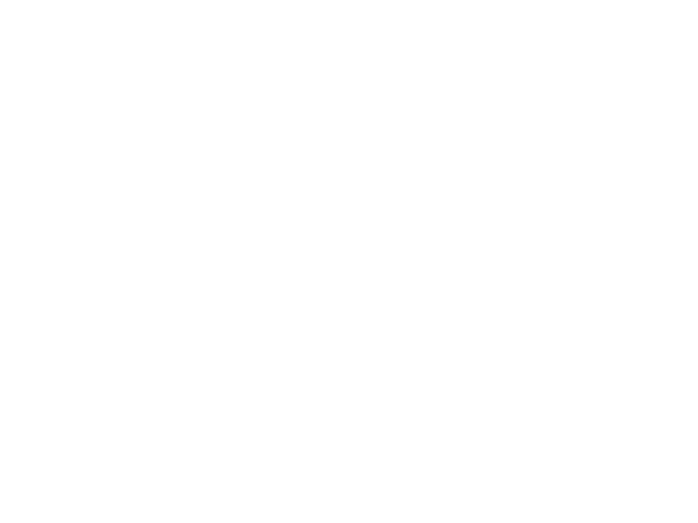

interactive(children=(IntSlider(value=0, description='i_frame', max=1), Output()), _dom_classes=('widget-inter…

<IPython.core.display.Javascript object>


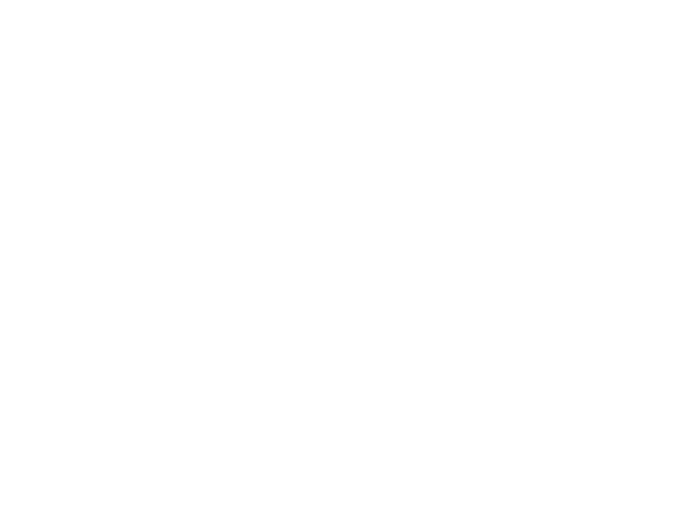

interactive(children=(IntSlider(value=0, description='i_frame', max=1), Output()), _dom_classes=('widget-inter…

<IPython.core.display.Javascript object>


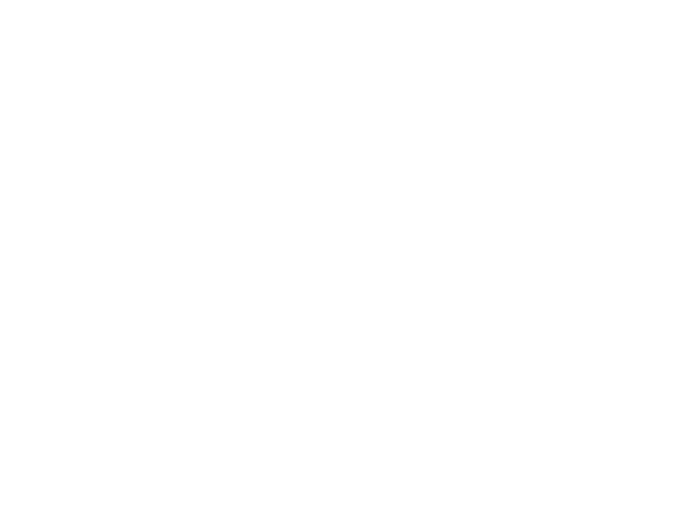

interactive(children=(IntSlider(value=0, description='i_frame', max=1), Output()), _dom_classes=('widget-inter…

<IPython.core.display.Javascript object>


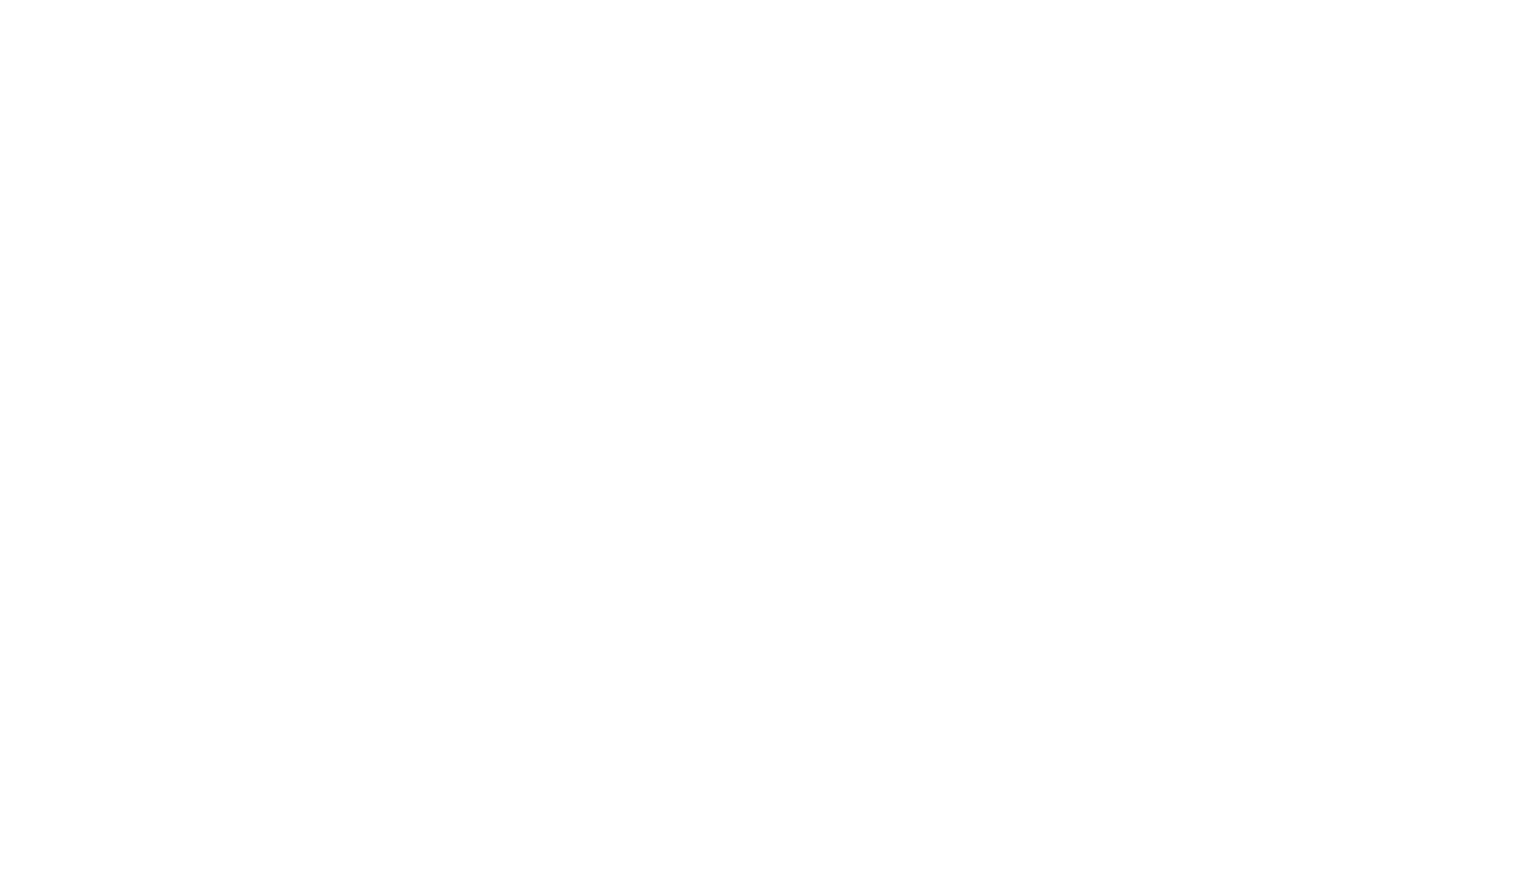

interactive(children=(IntSlider(value=0, description='i_frame', max=1), Output()), _dom_classes=('widget-inter…

In [19]:
%matplotlib notebook

visualization.display_toggle_image_stack(pcr.ims_registered[:])

visualization.display_toggle_image_stack(aligner.FOVs_aligned)
visualization.display_toggle_image_stack(aligner.get_ROIsAligned_maxIntensityProjection(), clim=[0,0.03])
visualization.display_toggle_2channel_image_stack(aligner.flows)

In [20]:
toc['alignment'] = time.time() - tic

## Blur ROIs (optional)

In [21]:
blurrer = blurring.ROI_Blurrer(
    frame_shape=(data.FOV_height, data.FOV_width),
    kernel_halfWidth=2,
    plot_kernel=False,
)

blurrer.blur_ROIs(
    spatialFootprints=aligner.ROIs_aligned[:],
)

Preparing the Toeplitz convolution matrix
Performing convolution for blurring


<IPython.core.display.Javascript object>


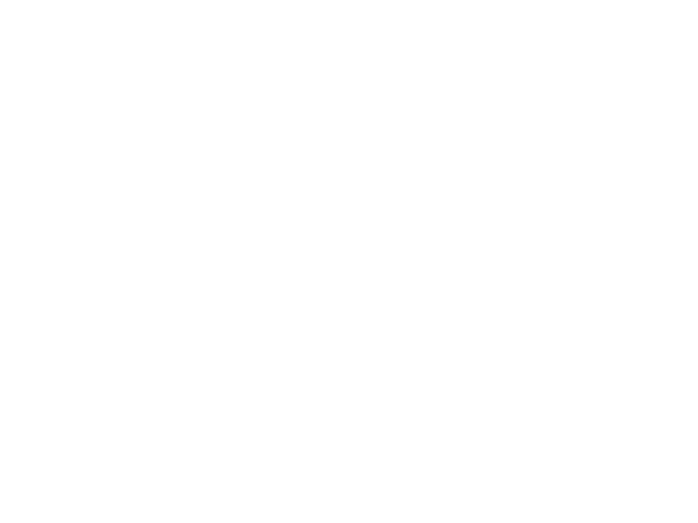

interactive(children=(IntSlider(value=0, description='i_frame', max=1), Output()), _dom_classes=('widget-inter…

In [22]:
%matplotlib notebook
visualization.display_toggle_image_stack(blurrer.get_ROIsBlurred_maxIntensityProjection())

In [23]:
toc['blur'] = time.time() - tic

## Neural network embedding distances

In [24]:
# data.um_per_pixel = 2.0

In [25]:

hash_dict_true = {
    'params': ('params.json', '68cf1bd47130f9b6d4f9913f86f0ccaa'),
    'model': ('model.py', '61c85529b7aa33e0dfadb31ee253a7e1'),
    'state_dict': ('ConvNext_tiny__1_0_best__simCLR.pth', '3287e001ff28d07ada2ae70aa7d0a4da'),
}

roinet = ROInet.ROInet_embedder(
    device='cuda:0',
    dir_networkFiles='/home/rich/Downloads/ROInet',
    
#     download_from_gDrive='force_download',
#     download_from_gDrive='force_local',
    download_from_gDrive='check_local_first',
    gDriveID='1D2Qa-YUNX176Q-wgboGflW0K6un7KYeN',
    hash_dict_networkFiles=hash_dict_true,
#     hash_dict_networkFiles=None,
    forward_pass_version='latent',
    verbose=True,
)

roinet.generate_dataloader(
    ROI_images=data.ROI_images,
    um_per_pixel=data.um_per_pixel,
    pref_plot=False,
    batchSize_dataloader=8,
    pinMemory_dataloader=True,
    numWorkers_dataloader=mp.cpu_count(),
    persistentWorkers_dataloader=True,
    prefetchFactor_dataloader=2,    
);

Successful hash comparison. Found matching files: {'params': '/home/rich/Downloads/ROInet/params.json', 'model': '/home/rich/Downloads/ROInet/model.py', 'state_dict': '/home/rich/Downloads/ROInet/ConvNext_tiny__1_0_best__simCLR.pth'}
Imported model from /home/rich/Downloads/ROInet/model.py
Loaded params_model from /home/rich/Downloads/ROInet/params.json


/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clust/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clust/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Generated network using params_model
Loaded state_dict into network from /home/rich/Downloads/ROInet/ConvNext_tiny__1_0_best__simCLR.pth
Loaded network onto device cuda:0
Starting: resizing ROIs


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 11.84it/s]

Completed: resizing ROIs


Defined image transformations: Sequential(
  (0): ScaleDynamicRange(scaler_bounds=(0, 1))
  (1): Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
  (2): TileChannels(dim=0)
)
Defined dataset
Defined dataloader


<IPython.core.display.Javascript object>


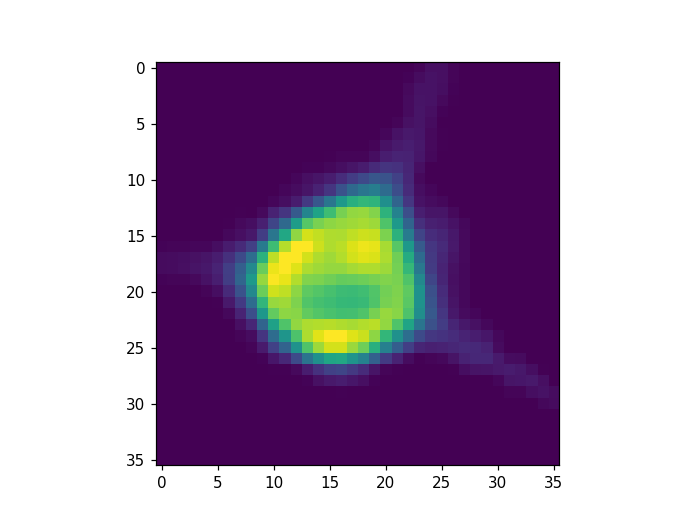

interactive(children=(IntSlider(value=0, description='i_frame', max=1437), Output()), _dom_classes=('widget-in…

In [26]:
%matplotlib notebook
visualization.display_toggle_image_stack(roinet.ROI_images_rs)

In [27]:
roinet.generate_latents();


starting: running data through network


  0%|                                                   | 0/180 [00:00<?, ?it/s]/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clust/lib/python3.9/site-packages/torch/nn/modules/module.py:1130: UserWarning: operator() profile_node %253 : int = prim::profile_ivalue(%out_dtype.1)
 does not have profile information (Triggered internally at  ../torch/csrc/jit/codegen/cuda/graph_fuser.cpp:104.)
  return forward_call(*input, **kwargs)
/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clust/lib/python3.9/site-packages/torch/nn/modules/module.py:1130: UserWarning: operator() profile_node %253 : int = prim::profile_ivalue(%out_dtype.1)
 does not have profile information (Triggered internally at  ../torch/csrc/jit/codegen/cuda/graph_fuser.cpp:104.)
  return forward_call(*input, **kwargs)
/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clust/lib/python3.9/site-packages/torch/nn/modules/module.py:1130: UserWarning: operator() profile_node 

/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clust/lib/python3.9/site-packages/torch/nn/modules/module.py:1130: UserWarning: operator() profile_node %253 : int = prim::profile_ivalue(%out_dtype.1)
 does not have profile information (Triggered internally at  ../torch/csrc/jit/codegen/cuda/graph_fuser.cpp:104.)
  return forward_call(*input, **kwargs)
/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clust/lib/python3.9/site-packages/torch/nn/modules/module.py:1130: UserWarning: operator() profile_node %253 : int = prim::profile_ivalue(%out_dtype.1)
 does not have profile information (Triggered internally at  ../torch/csrc/jit/codegen/cuda/graph_fuser.cpp:104.)
  return forward_call(*input, **kwargs)
/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clust/lib/python3.9/site-packages/torch/nn/modules/module.py:1130: UserWarning: operator() profile_node %253 : int = prim::profile_ivalue(%out_dtype.1)
 does not have profile informati

completed: running data through network


In [28]:
gc.collect()
torch.cuda.empty_cache()
gc.collect()
torch.cuda.empty_cache()

In [29]:
toc['NN'] = time.time() - tic

## Scattering wavelet embedding distances

In [30]:
swt = scatteringWaveletTransformer.SWT(
    kwargs_Scattering2D={'J': 2, 'L': 2}, 
    image_shape=data.ROI_images[0].shape[1:3], 
    device='cuda:0'
)

swt.transform(
    ROI_images=np.concatenate(data.ROI_images, axis=0),
    batch_size=100,
);

SWT initialized
Starting: SWT transform on ROIs


15it [00:00, 327.50it/s]                                                        

Completed: SWT transform on ROIs


In [31]:
gc.collect()
torch.cuda.empty_cache()
gc.collect()
torch.cuda.empty_cache()


In [32]:
toc['SWT'] = time.time() - tic

## Compute similarities

<IPython.core.display.Javascript object>


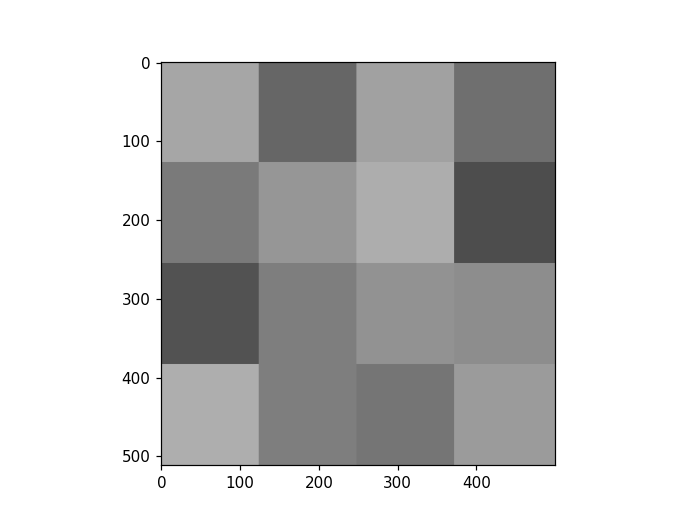

Computing pairwise similarity between ROIs...


100%|███████████████████████████████████████████| 16/16 [00:09<00:00,  1.68it/s]


Joining blocks into full similarity matrices...
Joining s_sf...


16it [00:00, 3182.93it/s]


Joining s_NN...


16it [00:00, 1994.73it/s]


Joining s_SWT...


16it [00:00, 3310.91it/s]


Joining s_sesh...


16it [00:00, 3802.63it/s]


In [33]:
sim = similarity_graph.ROI_graph(
    n_workers=-1,
    frame_height=data.FOV_height,
    frame_width=data.FOV_width,
#     block_height=data.FOV_height,
#     block_width=data.FOV_width,
    block_height=128,
    block_width=128,
    algorithm_nearestNeigbors_spatialFootprints='brute',
    verbose=True,
)

sim.visualize_blocks()

s_sf, s_NN, s_SWT, s_sesh = sim.compute_similarity_blockwise(
    spatialFootprints=blurrer.ROIs_blurred,
#     spatialFootprints=aligner.ROIs_aligned,
    features_NN=roinet.latents,
    features_SWT=swt.latents,
    ROI_session_bool=data.sessionID_concat,
    spatialFootprint_maskPower=0.8,
);

In [34]:
sim.make_normalized_similarities(
    centers_of_mass=data.centroids,
    features_NN=roinet.latents,
    features_SWT=swt.latents,
#     features_SWT=None,
    k_max=4000,
    k_min=100,
    algo_NN='kd_tree',
    device='cuda:0'
)

toc['sim'] = time.time() - tic

Finding k-range of center of mass distance neighbors for each ROI...
Normalizing Neural Network similarity scores...


100%|████████████████████████████████████| 1438/1438 [00:00<00:00, 17165.36it/s]


Normalizing SWT similarity scores...


100%|████████████████████████████████████| 1438/1438 [00:00<00:00, 17351.93it/s]


# Clustering

Finding mixing parameters using automated hyperparameter tuning...
Best value found: 0.11602000892162323 with parameters {'power_SF': 1.6453135080627848, 'power_NN': 1.1203702721084172, 'power_SWT': 0.43562453310669563, 'p_norm': -4.647028307893695, 'sig_SF_kwargs': None, 'sig_NN_kwargs': {'mu': 0.2223962241874618, 'b': 1.0296720148821068}, 'sig_SWT_kwargs': {'mu': 0.1637181136363824, 'b': 0.7132883364176488}}


<IPython.core.display.Javascript object>


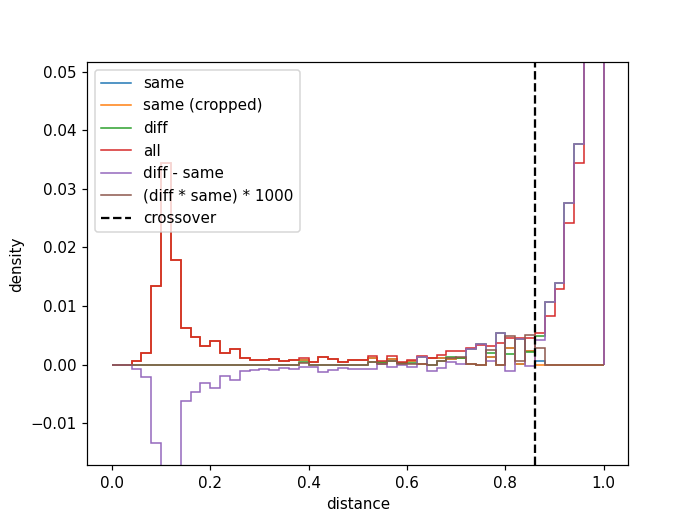

<IPython.core.display.Javascript object>


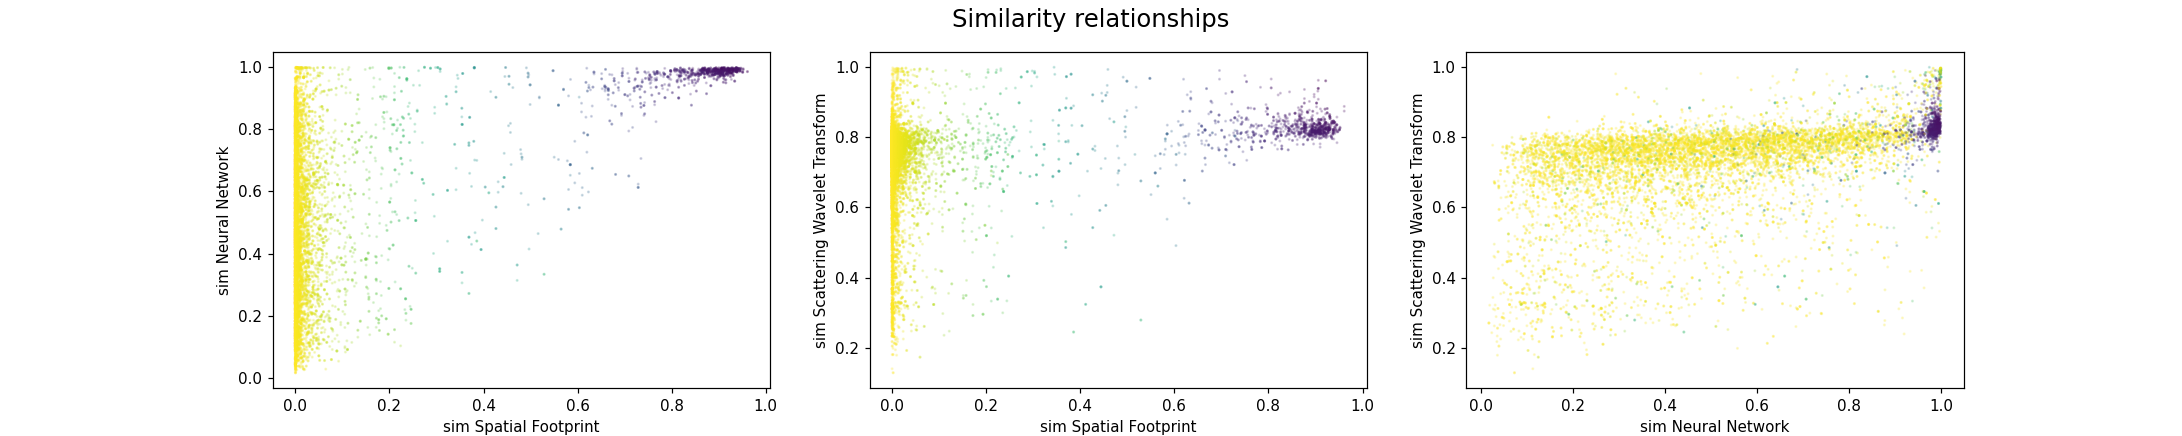

In [119]:
clusterer = clustering.Clusterer(
    s_sf=sim.s_sf,
    s_NN_z=sim.s_NN_z,
    s_SWT_z=sim.s_SWT_z,
    s_sesh=sim.s_sesh,
)

kwargs_makeConjunctiveDistanceMatrix_best = clusterer.find_optimal_parameters_for_pruning(
    n_bins=50,
    find_parameters_automatically=True,
    kwargs_findParameters={
        'n_patience': 100,
        'tol_frac': 0.05,
        'max_trials': 350,
        'max_duration': 60*10,
        'verbose': False,
    },
    bounds_findParameters={
        'power_SF': (0.3, 2),
        'power_NN': (0.2, 2),
        'power_SWT': (0.1, 1),
        'p_norm': (-5, 5),
        'sig_NN_kwargs_mu': (0, 0.5),
        'sig_NN_kwargs_b': (0.05, 2),
        'sig_SWT_kwargs_mu': (0, 0.5),
        'sig_SWT_kwargs_b': (0.05, 2),
    },
    n_jobs_findParameters=-1,    
#     fallback_d_cutoff=0.5,
#     plot_pref=True,
)

toc['separate_diffSame'] = time.time() - tic

clusterer.plot_distSame()

clusterer.plot_similarity_relationships(
    plots_to_show=[1,2,3], 
    max_samples=100000, 
    kwargs_scatter={'s':1, 'alpha':0.2},
    kwargs_makeConjunctiveDistanceMatrix=kwargs_makeConjunctiveDistanceMatrix_best,
#     kwargs_makeConjunctiveDistanceMatrix={
#         'power_SF': 1.0,
#         'power_NN': 1.0,
#         'power_SWT': 0.1,
#         'p_norm': -4.0,
#         'sig_SF_kwargs': {'mu':0.5, 'b':4},
# #         'sig_SF_kwargs': None,
#         'sig_NN_kwargs': {'mu':0.5, 'b':1.5},
#         'sig_SWT_kwargs': {'mu':0.5, 'b':0.5},
#     },
);

clusterer.make_pruned_similarity_graphs(
    kwargs_makeConjunctiveDistanceMatrix=kwargs_makeConjunctiveDistanceMatrix_best
)

In [91]:
if data.n_sessions >= 8:
    labels = clusterer.fit(
        session_bool=data.sessionID_concat,
        min_cluster_size=2,
        cluster_selection_method='leaf',
        d_clusterMerge=None,
        alpha=0.999,
        n_iter_violationCorrection=3,
        d_conj=None,
        kwargs_makeConjunctiveDistanceMatrix=kwargs_makeConjunctiveDistanceMatrix_best,
    #     kwargs_makeConjunctiveDistanceMatrix={
    #         'power_SF': 1.0,
    #         'power_NN': 1.0,
    #         'power_SWT': 0.1,
    #         'p_norm': -2,
    #         'sig_SF_kwargs': None,
    #         'sig_NN_kwargs':  {'mu':0, 'b':0.2},
    #         'sig_SWT_kwargs': {'mu':0, 'b':0.2},
    #     },
        split_intraSession_clusters=True,
        discard_failed_pruning=True,
        d_step=0.01,
    )

else:
    labels = clusterer.fit_sequentialHungarian(
        session_bool=data.sessionID_concat,
        thresh_cost=0.6,
        d_conj=None,
        kwargs_makeConjunctiveDistanceMatrix=kwargs_makeConjunctiveDistanceMatrix_best,
    #     kwargs_makeConjunctiveDistanceMatrix={
    #     'power_SF': 1.0,
    #     'power_NN': 1.0,
    #     'power_SWT': 0.1,
    #     'p_norm': -2,
    #     'sig_SF_kwargs': None,
    #     'sig_NN_kwargs':  {'mu':0, 'b':0.2},
    #     'sig_SWT_kwargs': {'mu':0, 'b':0.2},
    #     },
    )

labels_bySession = [labels[idx] for idx in data.sessionID_concat.T]

Clustering with CaImAn's sequential Hungarian algorithm method...


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 84.71it/s]


In [92]:
## results_clustering
print(f'Number of clusters: {len(np.unique(labels))}')
print(f'Number of discarded ROIs: {(labels==-1).sum()}')

Number of clusters: 616
Number of discarded ROIs: 208


In [93]:
toc['clustering'] = time.time() - tic

# Visualize results

In [94]:
FOV_clusters = visualization.compute_colored_FOV(
    spatialFootprints=[r.power(0.7) for r in aligner.ROIs_aligned],
    FOV_height=data.FOV_height,
    FOV_width=data.FOV_width,
    boolSessionID=data.sessionID_concat,
    labels=labels,
    confidence=None,
)

<IPython.core.display.Javascript object>


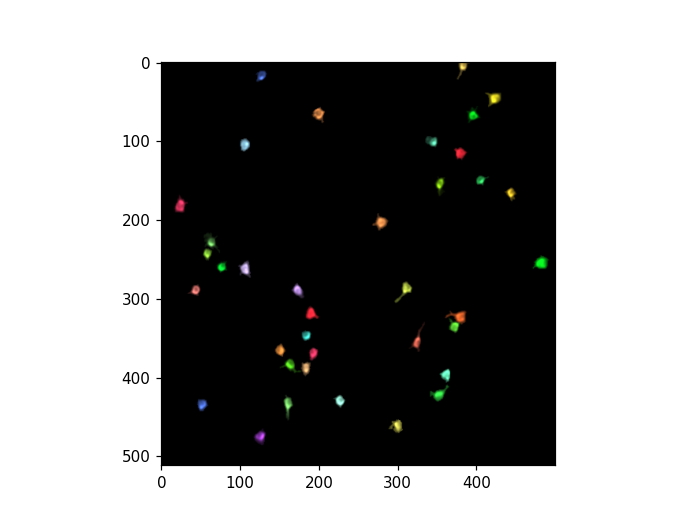

interactive(children=(IntSlider(value=0, description='i_frame', max=1), Output()), _dom_classes=('widget-inter…

In [115]:
%matplotlib notebook
visualization.display_toggle_image_stack(
    FOV_clusters, 
#     interpolation='none', 
#     filternorm=False, 
#     resample=False
)

In [96]:
# visualization.display_toggle_image_stack(aligner.get_ROIsAligned_maxIntensityProjection())

/tmp/ipykernel_81895/2710547728.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(40,1))


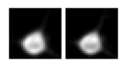

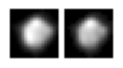

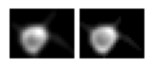

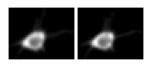

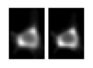

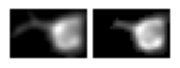

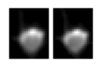

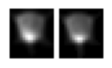

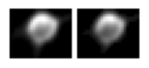

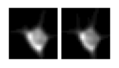

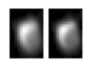

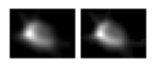

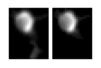

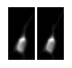

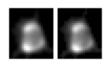

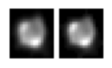

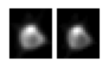

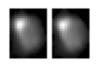

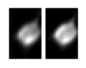

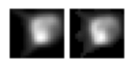

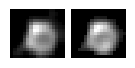

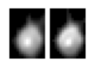

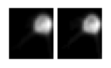

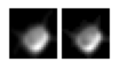

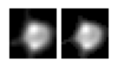

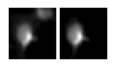

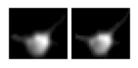

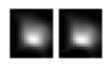

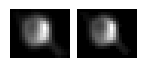

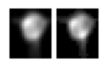

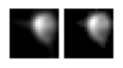

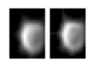

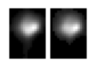

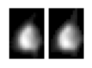

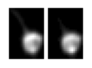

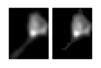

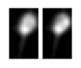

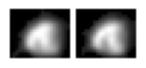

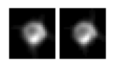

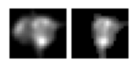

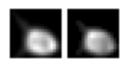

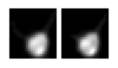

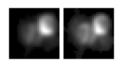

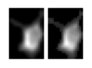

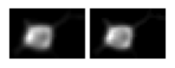

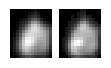

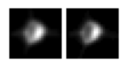

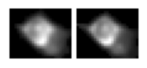

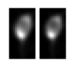

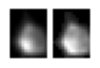

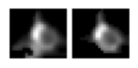

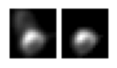

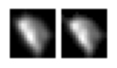

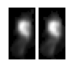

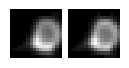

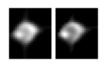

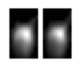

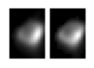

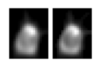

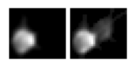

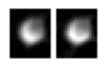

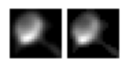

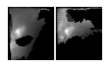

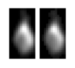

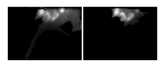

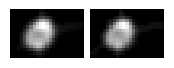

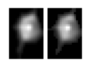

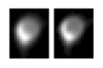

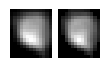

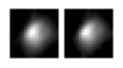

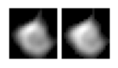

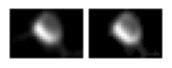

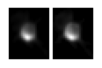

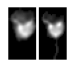

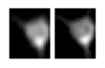

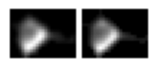

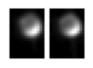

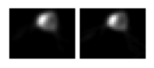

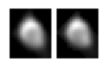

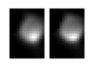

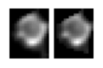

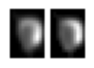

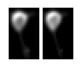

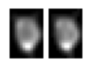

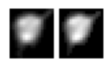

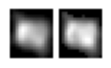

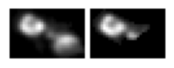

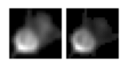

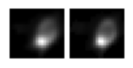

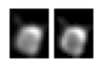

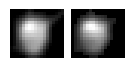

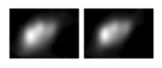

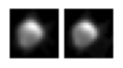

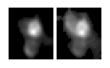

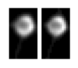

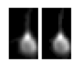

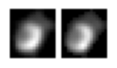

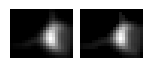

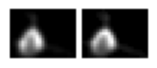

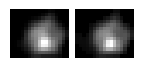

In [97]:
import scipy.sparse

ucids = labels.copy()
# ucids = ucids[ucids==975]
ucids_unique = np.unique(ucids[ucids>-1])

# ROI_ims = np.concatenate(data.ROI_images, axis=0)
ROI_ims_sparse = scipy.sparse.vstack(aligner.ROIs_aligned)
ROI_ims_sparse = ROI_ims_sparse.multiply( ROI_ims_sparse.max(1).power(-1) ).tocsr()


ucid_sfCat = []
for ucid in ucids_unique:
    idx = np.where(ucids == ucid)[0]
    ucid_sfCat.append( np.concatenate(list(visualization.crop_cluster_ims(ROI_ims_sparse[idx].toarray().reshape(len(idx), data.FOV_height, data.FOV_width))), axis=1) )
#     ucid_sfCat.append( np.concatenate(list(ROI_ims_sparse[idx].toarray().reshape(len(idx), data.FOV_height, data.FOV_width)), axis=1) )
# data.ROI_images[i_sesh][idx] for 


%matplotlib inline

for sf in ucid_sfCat[:100]:
    plt.figure(figsize=(40,1))
    plt.imshow(sf, cmap='gray')
    plt.axis('off')

<IPython.core.display.Javascript object>


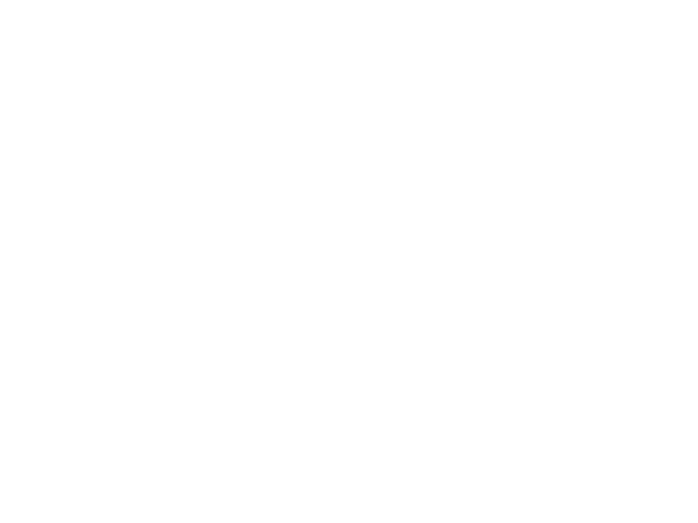

In [98]:
%matplotlib notebook

_, counts = np.unique(labels, return_counts=True)

plt.figure()
plt.hist(counts, 30, range=(0, data.n_sessions+1));


In [99]:
toc['visualize'] = time.time() - tic

# Save results

In [100]:
# dir_save = Path('/home/rich/Desktop/').resolve()
# name_save = dir_allOuterFolders.name
# path_save = dir_save / (name_save + '.ROICaT.results' + '.pkl')

# ROIs = {
#     "ROIs_aligned": aligner.ROIs_aligned,
#     "ROIs_raw": data.spatialFootprints,
#     "frame_height": data.FOV_height,
#     "frame_width": data.FOV_width,
#     "idx_roi_session": np.where(data.sessionID_concat)[1]
# }

# results = {
#     "UCIDs": labels,
#     "UCIDs_bySession": labels_bySession,
#     "ROIs": ROIs,
# }

# helpers.pickle_save(
#     obj=results,
#     filename=path_save,
#     mkdir=True,
# )

In [101]:
toc['saving'] = time.time() - tic

In [102]:
toc

{'start': 4.410743713378906e-05,
 'import_paths': 50.28519606590271,
 'import_data': 98.66442966461182,
 'alignment': 105.30216383934021,
 'blur': 105.68386650085449,
 'NN': 116.29859638214111,
 'SWT': 116.99120688438416,
 'sim': 127.33210253715515,
 'separate_diffSame': 1216.55770611763,
 'clustering': 1217.3034591674805,
 'visualize': 1221.3440606594086,
 'saving': 1221.47398853302}

In [103]:
from basic_neural_processing_modules import path_helpers

In [104]:
paths_labelsDict = path_helpers.find_paths(
    dir_outer='/media/rich/bigSSD/other lab data/Harvey_lab_ROIs/Sofia_ROIs/Data for Rich/SS40',
    reMatch='Slice06/labels_dict.npy',
    depth=4,
)

In [105]:
paths_labelsDict

['/media/rich/bigSSD/other lab data/Harvey_lab_ROIs/Sofia_ROIs/Data for Rich/SS40/200130/Slice06/labels_dict.npy',
 '/media/rich/bigSSD/other lab data/Harvey_lab_ROIs/Sofia_ROIs/Data for Rich/SS40/200131/Slice06/labels_dict.npy']

In [106]:
labels_sofia_files = [np.load(p, allow_pickle=True)[()] for p in paths_labelsDict]

In [107]:
labels_sofia = [{key: np.array([l[key] for l in ls]) for key in ['source_indx', 'source_id_sia']} for ls in labels_sofia_files]

In [108]:
ucids_bySession_gt = [np.ones(n, dtype=int)*-1 for n in data.n_roi]

In [109]:
for ii in range(len(ucids_bySession_gt)):
    ucids_bySession_gt[ii][labels_sofia[ii]['source_indx']-1] = labels_sofia[ii]['source_id_sia']

In [110]:
ucids_cat_sofia = np.concatenate(ucids_bySession_gt)

In [111]:
u, c = np.unique(ucids_cat_sofia, return_counts=True)
ucids_cat_sofia[np.isin(ucids_cat_sofia, u[c==1])] = -1

In [112]:
FOV_clusters = visualization.compute_colored_FOV(
    spatialFootprints=[r.power(0.7) for r in aligner.ROIs_aligned],
    FOV_height=data.FOV_height,
    FOV_width=data.FOV_width,
    boolSessionID=data.sessionID_concat,
    labels=ucids_cat_sofia,
    confidence=None,
)

<IPython.core.display.Javascript object>


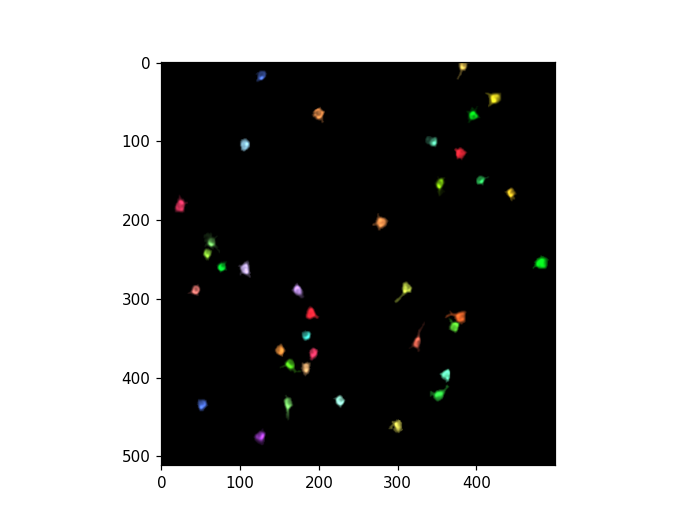

interactive(children=(IntSlider(value=0, description='i_frame', max=1), Output()), _dom_classes=('widget-inter…

In [113]:
%matplotlib notebook
visualization.display_toggle_image_stack(
    FOV_clusters, 
#     interpolation='none', 
#     filternorm=False, 
#     resample=False
)

In [114]:
clustering.score_labels(
    labels_test=labels,
    labels_true=ucids_cat_sofia,
    ignore_negOne=True,
    compute_mutual_info=True
)

{'score_weighted_partial': 1.0,
 'score_weighted_perfect': 1.0,
 'score_unweighted_partial': 1.0,
 'score_unweighted_perfect': 1.0,
 'adj_rand_score': 1.0,
 'adj_mutual_info_score': 1.0,
 'ignore_negOne': True,
 'idx_hungarian': (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
         17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
         34, 35, 36]),
  array([12, 30, 29,  1, 19, 25, 16, 11,  7,  8, 33, 18, 35, 32, 22, 23, 13,
          0,  5, 15,  4, 26, 36, 10, 31, 14,  3,  6,  2, 27, 17, 20, 24, 21,
         28,  9, 34]))}